In [1]:
import numpy as np
import scipy.interpolate as si
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad
from skfda.preprocessing.dim_reduction import FPCA
import torch
import torch.nn as nndata
import torch.optim as optim
from models_HLS import *
from data_generation_new import *
from utils import *
from training_HLS import *
from pathlib import Path
from skfda.representation.grid import FDataGrid
from skfda.representation.basis import FourierBasis
from skfda.preprocessing.smoothing import BasisSmoother

# Data Preprocessing

In [2]:
file = Path("../data/MinTemp_combined_cleaned.csv")          # adjust name/path
#file = Path("../data/MinTempGayndah_Data.csv")
df = pd.read_csv(file)
df = df[~((df["Month"] == 2) & (df["Day"] == 29))].copy()
df['Date'] = pd.to_datetime(dict(year=df.Year,
                                 month=df.Month,
                                 day=df.Day))
df['doy']  = df['Date'].dt.dayofyear
df['t']    = (df['doy'] - 1) / 365.0

In [3]:
mat = (df.pivot(index='Year', columns='doy',
                values='Minimum temperature (Degree C)')
         .reindex(columns=range(1, 366)))      # ensure 365 cols
mat = mat.reset_index(drop=True)
mat = mat.interpolate(axis=1, limit_direction='both')  # simple fill

# grid points in [0,1] that match the columns
grid_pts = (np.arange(1, 366) - 1) / 365.0

# Detrend

In [4]:
def detrend_functional_series(
    X: np.ndarray,
    breaks,
    breaks_are_1_based=True,
    smooth_mean=False,
    smooth_window=7,
):
    """
    Piecewise-mean detrending for functional time series with structural breaks.

    Parameters
    ----------
    X : array (n_years, n_time)
        Rows = years, columns = observation grid within a year (e.g., days).
    breaks : list/tuple of ints
        Break locations k such that the mean changes at these indices.
        If breaks_are_1_based=True, a value k means the last index in the *previous*
        regime is k (i.e., segments are [1..k], [k+1..next_k], ... in 1-based terms).
        If breaks_are_1_based=False, treat them as 0-based inclusive ends.
    breaks_are_1_based : bool
        See above.
    smooth_mean : bool
        If True, apply a simple moving-average smoother to each segment mean curve.
        (Keeps things dependency-free; swap for splines if you prefer.)
    smooth_window : int
        Odd window length for the moving average (along the time axis).

    Returns
    -------
    Y : array (n_years, n_time)
        Detrended series (X minus its segment-wise mean function).
    segment_means : list of arrays
        Mean curve for each segment, length = n_segments, each shape (n_time,).
    segment_ids : array (n_years,)
        Segment index (0..n_segments-1) for each year.
    segments : list of (start_idx, end_idx)
        0-based inclusive year index ranges for each segment.
    """
    X = np.asarray(X)
    if X.ndim != 2:
        raise ValueError("X must be 2D (n_years, n_time)")
    n_years, n_time = X.shape

    # --- build segments from breaks
    b = list(breaks)
    if breaks_are_1_based:
        # convert 1-based inclusive end indices to 0-based inclusive ends
        b = [k - 1 for k in b]

    if any(k < 0 or k >= n_years - 1 for k in b):
        raise ValueError("Breaks must be within [0, n_years-2] after normalization.")
    if any(b[i] >= b[i+1] for i in range(len(b)-1)):
        raise ValueError("Breaks must be strictly increasing.")

    # segments are [0..b1], [b1+1..b2], ..., [b_last+1..n_years-1]
    starts = [0] + [k + 1 for k in b]
    ends   = b + [n_years - 1]
    segments = list(zip(starts, ends))

    # --- helper: simple moving average along time axis
    def _smooth(curve, win):
        win = max(1, int(win))
        if win % 2 == 0:
            win += 1  # enforce odd
        if win == 1:
            return curve
        pad = win // 2
        # reflect padding to avoid edge shrink
        padded = np.pad(curve, (pad, pad), mode="reflect")
        kernel = np.ones(win) / win
        return np.convolve(padded, kernel, mode="valid")

    # --- compute segment means and detrend
    segment_means = []
    segment_ids = np.empty(n_years, dtype=int)
    Y = np.empty_like(X, dtype=float)

    for s_idx, (a, b_) in enumerate(segments):
        segment_ids[a:b_+1] = s_idx

        # mean curve for this segment; handle NaNs with nanmean
        mu = np.nanmean(X[a:b_+1, :], axis=0)

        if smooth_mean and mu.size > 1:
            mu = _smooth(mu, smooth_window)

        segment_means.append(mu)

        # subtract
        Y[a:b_+1, :] = X[a:b_+1, :] - mu[np.newaxis, :]

    return Y, segment_means, segment_ids, segments


In [5]:
# Detrend 
## Break points: 1953(k1 = 60), 1972(k2 = 79), 2008(k3 = 115)
# Convert to numpy
X = mat.to_numpy(dtype=float)

Y, seg_means, seg_ids, segs = detrend_functional_series(
    X, breaks=[60, 79, 115], breaks_are_1_based=True, smooth_mean=False
)

mat_detrended = pd.DataFrame(Y, index=mat.index, columns=mat.columns)


In [30]:
len(seg_means)

4

In [6]:
mat_detrended.shape

(131, 365)

In [31]:
fd_grid_nodetrend   = FDataGrid(data_matrix=mat.to_numpy(),
                      grid_points=grid_pts,
                      dataset_name="Daily Tmin Without Detrending",
                      argument_names=("t",),
                      coordinate_names=("Tmin °C",))

J = 21
F_basis     = FourierBasis(domain_range=(0, 1), n_basis=J)    
smoother  = BasisSmoother(basis=F_basis, return_basis=True)     
fd_basis_nodetrend  = smoother.fit_transform(fd_grid_nodetrend)   


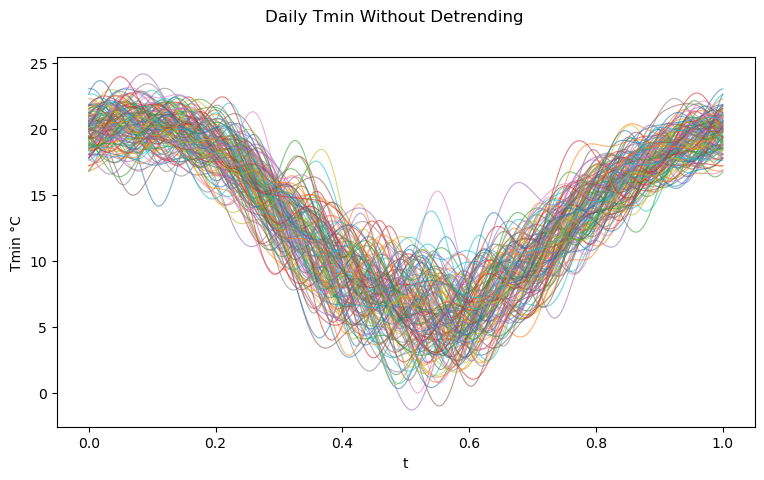

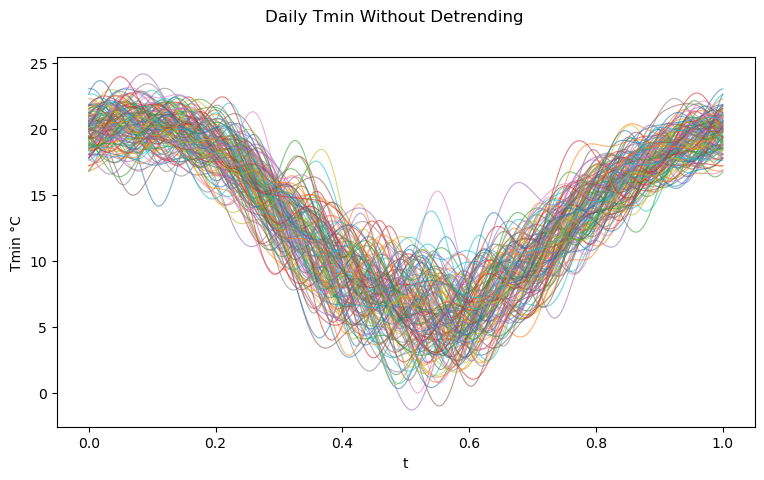

In [43]:
fig, ax = plt.subplots(figsize=(9, 4.8))
fd_basis_nodetrend.plot(axes=ax, alpha=0.6, linewidth=0.8)

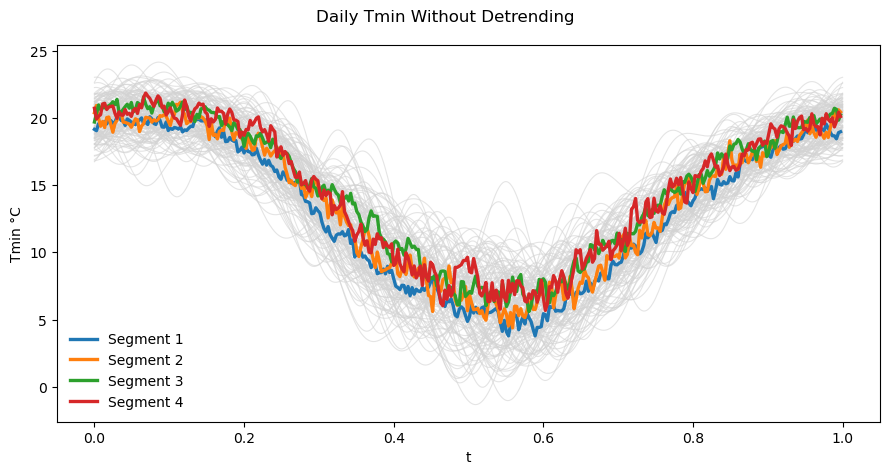

Text(0.5, 1.0, '')

In [44]:
fig, ax = plt.subplots(figsize=(9, 4.8))
fd_basis_nodetrend.plot(axes=ax, color="lightgray", alpha=0.6, linewidth=0.8, )

# Use segment_means from detrend_functional_series (already on the observation grid)
for j, (mu, (a, b)) in enumerate(zip(seg_means, segs)):
    ax.plot(grid_pts, mu, linewidth=2.4,
            label=f"Segment {j+1}")

ax.legend(frameon=False)
plt.tight_layout()
plt.show()
ax.set_title(None)

Text(0.5, 1.0, '')

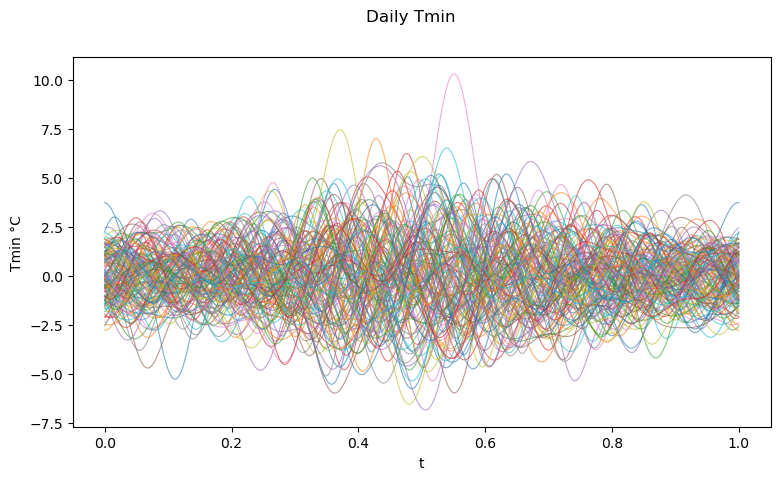

In [45]:
fd_grid   = FDataGrid(data_matrix=mat_detrended.to_numpy(),
                      grid_points=grid_pts,
                      dataset_name="Daily Tmin",
                      argument_names=("t",),
                      coordinate_names=("Tmin °C",))

J = 21
F_basis     = FourierBasis(domain_range=(0, 1), n_basis=J)    
smoother  = BasisSmoother(basis=F_basis, return_basis=True)     
fd_basis  = smoother.fit_transform(fd_grid)   
fig, ax = plt.subplots(figsize=(9, 4.8))
fd_basis.plot(axes=ax, alpha=0.6, linewidth=0.8)   
ax.set_title(None)

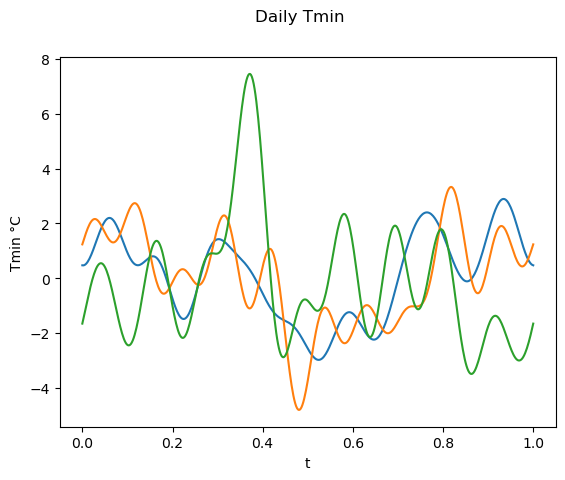

In [8]:
fig = fd_basis[[1,2, -3]].plot()

In [9]:
# Conduct FPCA
mean_fd = fd_basis.mean()
fd_centered = fd_basis - mean_fd

fpca_fbasis = FPCA(n_components=16)
fpca_fbasis.fit(fd_centered)
scores = fpca_fbasis.transform(fd_centered)

# Explained variance ratio
print("Explained variance by each PC:", fpca_fbasis.explained_variance_ratio_)
print(sum(fpca_fbasis.explained_variance_ratio_))

Explained variance by each PC: [0.1619348  0.10712064 0.08513244 0.07735589 0.07092438 0.06248445
 0.05105427 0.04641793 0.04071129 0.03921076 0.03630331 0.03305456
 0.03104343 0.0294489  0.02552765 0.02232894]
0.9200536523933057


/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:231: RuntimeWarning: divide by zero encountered in matmul
  final_matrix = X.coefficients @ np.transpose(l_inv_j_t)
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:231: RuntimeWarning: overflow encountered in matmul
  final_matrix = X.coefficients @ np.transpose(l_inv_j_t)
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:231: RuntimeWarning: invalid value encountered in matmul
  final_matrix = X.coefficients @ np.transpose(l_inv_j_t)
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:281: RuntimeWarning: divide by zero encountered in matmul
  X.coefficients @ self._j_matrix
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:281: RuntimeWarning: overflow encountered in matmul
  X.coeffi

In [10]:
E_coef = fpca_fbasis.components_.coefficients 
#print(E_coef)
E_coef.shape

(16, 21)

In [11]:
X_coef = fd_basis.coefficients
d = X_coef.shape[0]
# Compute the integral of each basis function over [0,1]
def basis_integral(j):
    """Compute the integral of the j-th basis function over [0,1]."""
    return quad(lambda s: F_basis(s)[j], 0, 1)[0]

I_j = np.array([basis_integral(j) for j in range(J)])

# Define beta coefficients (random or fixed values)
beta = np.random.randn(J)

# Compute Y
noise = np.random.normal(0, 1, size=d)
Y_np = np.sum(X_coef * beta * I_j, axis=1) + noise

In [12]:
Y_np = scores[-1]
Y_np.shape

(16,)

In [13]:
center_dat = scores[:-1]
center_dat.shape

(130, 16)

In [14]:
X = torch.tensor(center_dat, dtype=torch.float32) 
print(X.size())
Y = torch.tensor(Y_np, dtype=torch.float32).view(-1, 1)
print(Y.size())

torch.Size([130, 16])
torch.Size([16, 1])


# Model adding covariates

In [15]:
# Parameters
d = X.shape[0]
porder = 0
band = round(d**(1/3)) # the bandwidth
print(band)

5


In [16]:
cov_weighted, cov_unweighted, cov_triple =cov_l(X, porder, band, kern_type = "Bartlett")
cov_weighted

tensor([[ 0.3845, -0.0423, -0.0224, -0.0376, -0.0446,  0.0302,  0.0069, -0.0199,
         -0.0393,  0.0300, -0.0553, -0.0386, -0.0154,  0.0466, -0.0100,  0.0153],
        [-0.0423,  0.2532, -0.0089,  0.0343, -0.0119,  0.0138, -0.0461,  0.0206,
          0.0381, -0.0031, -0.0029,  0.0054,  0.0470, -0.0215, -0.0127,  0.0080],
        [-0.0224, -0.0089,  0.2131,  0.0550,  0.0522, -0.0505, -0.0389,  0.0077,
          0.0340,  0.0284, -0.0093,  0.0369,  0.0326, -0.0126,  0.0072,  0.0086],
        [-0.0376,  0.0343,  0.0550,  0.3162,  0.0363,  0.0320,  0.0066, -0.0053,
          0.0262,  0.0108,  0.0036,  0.0118,  0.0145, -0.0092,  0.0222,  0.0056],
        [-0.0446, -0.0119,  0.0522,  0.0363,  0.2312,  0.0381, -0.0006,  0.0128,
          0.0323, -0.0033, -0.0190, -0.0040,  0.0054, -0.0125, -0.0058,  0.0271],
        [ 0.0302,  0.0138, -0.0505,  0.0320,  0.0381,  0.2422,  0.0098, -0.0107,
         -0.0603,  0.0178,  0.0172,  0.0074,  0.0124, -0.0076,  0.0172,  0.0179],
        [ 0.0069, -0.0

In [17]:
cov_weighted_np = cov_weighted.detach().numpy()
cov_weighted_transform = E_coef.T @ cov_weighted_np @ E_coef
print("The estimated LR covariance matrix is:")
print(np.round(cov_weighted_transform,4))
print("The trace of the estimated LR covariance matrix is:")
print(sum(np.diag(cov_weighted_transform)))

The estimated LR covariance matrix is:
[[ 4.214e-01 -1.670e-02 -5.930e-02  5.000e-03  1.590e-02  3.030e-02
   9.300e-03  3.590e-02 -2.320e-02 -3.040e-02  7.210e-02  2.400e-03
  -2.980e-02 -1.080e-02  1.090e-02 -1.250e-02 -5.130e-02  4.300e-03
   1.700e-03  1.240e-02 -1.300e-02]
 [-1.670e-02  1.818e-01 -3.700e-03 -7.160e-02 -1.780e-02 -1.250e-02
   1.700e-03  9.600e-03  1.460e-02 -2.670e-02  4.490e-02  9.000e-04
  -2.490e-02  5.300e-03  3.900e-03 -7.100e-03 -2.300e-03  1.350e-02
  -2.500e-02 -2.700e-02  7.300e-03]
 [-5.930e-02 -3.700e-03  2.526e-01  4.090e-02 -4.600e-02 -1.000e-03
   1.710e-02 -9.500e-03 -1.850e-02  3.820e-02 -2.900e-03 -1.310e-02
  -1.900e-02  2.600e-02  1.230e-02 -2.060e-02 -8.400e-03 -1.600e-03
  -2.900e-02 -6.300e-03  3.060e-02]
 [ 5.000e-03 -7.160e-02  4.090e-02  1.257e-01 -1.400e-02 -3.840e-02
  -1.300e-03 -1.270e-02 -1.710e-02 -9.200e-03 -2.070e-02 -2.000e-03
  -6.400e-03 -6.400e-03  2.550e-02 -2.480e-02 -1.420e-02  5.200e-03
   1.110e-02  1.660e-02 -1.470e-02]
 

/var/folders/2_/9kbwkkv57wn779njgp9cjhg40000gn/T/ipykernel_86189/1761596041.py:2: RuntimeWarning: divide by zero encountered in matmul
  cov_weighted_transform = E_coef.T @ cov_weighted_np @ E_coef
/var/folders/2_/9kbwkkv57wn779njgp9cjhg40000gn/T/ipykernel_86189/1761596041.py:2: RuntimeWarning: overflow encountered in matmul
  cov_weighted_transform = E_coef.T @ cov_weighted_np @ E_coef
/var/folders/2_/9kbwkkv57wn779njgp9cjhg40000gn/T/ipykernel_86189/1761596041.py:2: RuntimeWarning: invalid value encountered in matmul
  cov_weighted_transform = E_coef.T @ cov_weighted_np @ E_coef


Stopping early at Epoch [60/5000], Loss: 0.000072

Restoring best model weights...


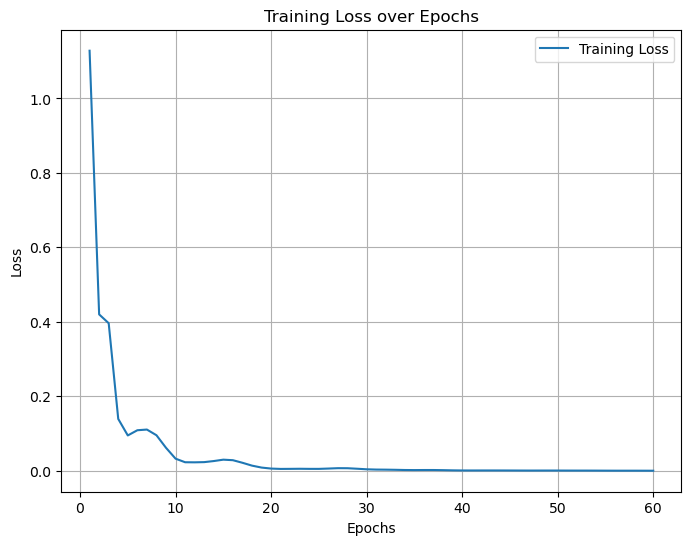

In [18]:
trained_model, losses, best_cov = train_model(
    X=X, Y=Y,
    ModelClass=Model1_new,
    porder=porder,
    band=band,
    kern_type= "Bartlett",
    hidden_dim=64,
    lr=0.01,
    epochs=5000,
    patience=300
)


Shape of Covariance Matrix (NumPy): (16, 16)


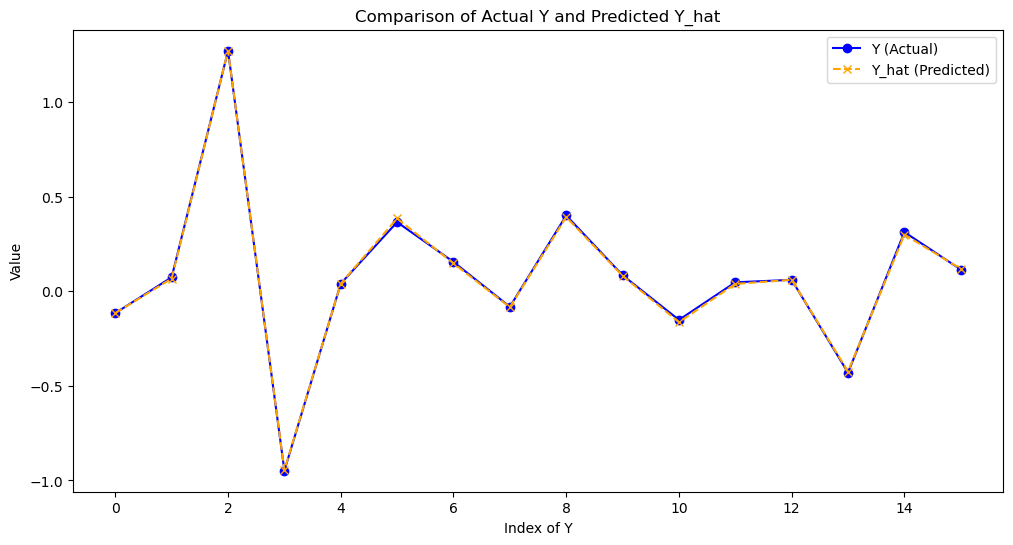

In [19]:
# Compute the best covariance matrix and predictions using the best model
with torch.no_grad():
    cov_weighted, cov_unweighted, cov_triple =cov_l(X, porder, band, kern_type = "Bartlett")
    cov_weighted_np = cov_weighted.cpu().numpy()  # Convert to NumPy

    # Print shape of the covariance matrix
    print("\nShape of Covariance Matrix (NumPy):", cov_weighted_np.shape)

    Y_hat = trained_model(X).view(-1).detach()  
    Y_actual = Y.view(-1).detach()  

# Plotting Y and Y_hat
plt.figure(figsize=(12, 6))
plt.plot(range(len(Y_actual)), Y_actual.cpu(), label='Y (Actual)', marker='o', linestyle='-', color='blue')
plt.plot(range(len(Y_hat)), Y_hat.cpu(), label='Y_hat (Predicted)', marker='x', linestyle='--', color='orange')

plt.xlabel("Index of Y")
plt.ylabel("Value")
plt.title("Comparison of Actual Y and Predicted Y_hat")
plt.legend()
plt.show()


In [20]:
# 1. Estimate the mean coefficient vector
X_coef_mean = X_coef.mean(axis=0)  # shape: (n_basis,)

# 2. Evaluate Fourier basis on a fine grid
u_grid = np.linspace(0, 1, 200)
phi_u = F_basis.evaluate(u_grid)[:,:,0] # shape: (n_basis, n_grid)

# 3. Compute the mean function: sum_j mean_coef_j * phi_j(u)
mean_curve = phi_u.T @ X_coef_mean  # shape: (n_grid,)

# 4. Compute pointwise variance using the long-run covariance matrix
n = X_coef.shape[0]
var_curve = np.einsum('ij,jk,ik->i', phi_u.T, cov_weighted_transform / n, phi_u.T)

# 5. Construct 95% pointwise confidence intervals
z = 1.96
upper_band = mean_curve + z * np.sqrt(var_curve)
lower_band = mean_curve - z * np.sqrt(var_curve)


/var/folders/2_/9kbwkkv57wn779njgp9cjhg40000gn/T/ipykernel_86189/3382184743.py:6: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  phi_u = F_basis.evaluate(u_grid)[:,:,0] # shape: (n_basis, n_grid)
/var/folders/2_/9kbwkkv57wn779njgp9cjhg40000gn/T/ipykernel_86189/3382184743.py:9: RuntimeWarning: divide by zero encountered in matmul
  mean_curve = phi_u.T @ X_coef_mean  # shape: (n_grid,)
/var/folders/2_/9kbwkkv57wn779njgp9cjhg40000gn/T/ipykernel_86189/3382184743.py:9: RuntimeWarning: overflow encountered in matmul
  mean_curve = phi_u.T @ X_coef_mean  # shape: (n_grid,)
/var/folders/2_/9kbwkkv57wn779njgp9cjhg40000gn/T/ipykernel_86189/3382184743.py:9: RuntimeWarning: invalid value encountered in matmul
  mean_curve = phi_u.T @ X_coef_mean  # shape: (n_grid,)


In [21]:
X_coef_mean

array([-2.45774563e-17, -1.44074744e-16,  1.14412296e-17, -7.55333031e-17,
        1.93229656e-16, -5.86892706e-17,  1.81364677e-16,  7.94529836e-17,
        4.02561784e-17,  7.20373718e-17, -3.89849306e-17,  1.45875678e-16,
        3.68661844e-17, -7.41561181e-19,  1.77974683e-17, -5.50609177e-17,
        9.23773356e-17, -5.99605183e-17,  1.86449668e-17, -2.58487040e-17,
        4.56060126e-17])

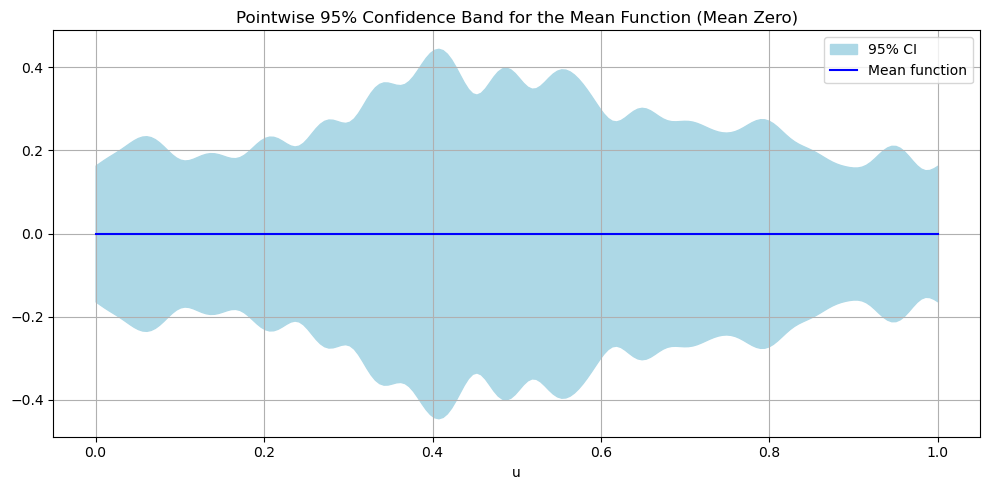

In [41]:
plt.figure(figsize=(10, 5))

# Plot the 95% confidence band as a shaded region
plt.fill_between(u_grid, lower_band-mean_curve, upper_band-mean_curve, color='lightblue', label='95% CI')

# Plot the mean function
plt.plot(u_grid, np.zeros_like(mean_curve), color='blue', label='Mean function')

# Axis labels and legend
plt.xlabel("u")
plt.title("Pointwise 95% Confidence Band for the Mean Function (Mean Zero)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
np.mean(upper_band-lower_band)

np.float64(0.5320991911674254)